# NLP Techniques Lab

In this lab, we'll be practicing a set of advanced NLP techniques using tweets on airline satisfaction ([originally from Kaggle](https://www.kaggle.com/crowdflower/twitter-airline-sentiment/data)).

The first section asks you to perform LDA on the dataset to summarize the body of tweets. The second section will focus on using this data to predict the sentiment of a given tweet.

Import the data as follows:

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
# Load and view dataset
df = pd.read_csv('datasets/Tweets.csv')
print(df.shape)
df.head()

(14640, 15)


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Use this data to do the following:

#### 1. Use LDA to identify topics in the tweets

Pick a number of topics between 5-20 and use LDA to summarize the corpus of tweets. Print out the top 25 most frequently occuring words in each topic. Do the topics appear cohesive to you? What predominant trends can you find?

In [26]:
# Use CountVectorizer to transform the data and remove stop words
cv = CountVectorizer(stop_words='english')
cv.fit(df['text'])
X = cv.transform(df['text'])
feature_names = cv.get_feature_names()

X

<14640x14770 sparse matrix of type '<class 'numpy.int64'>'
	with 133911 stored elements in Compressed Sparse Row format>

In [27]:
# Instantiate an LDA with 10 topics and fit to sparse matrix of words 
lda = LatentDirichletAllocation(n_components=10)
lda.fit(X)

/Users/mariayarolin/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [28]:
print(lda.components_.shape)
# 10 rows, 14,770 columns. 
# Each row of this array is one of our topics and each column (in order) is a word created by CountVectorizer.

(10, 14770)


In [21]:
# store the array as a dataframe
results = pd.DataFrame(lda.components_, columns=feature_names)

In [22]:
# Examine the words that are most likely in each topic
for topic in range(10):
    print('Topic', topic)
    word_list = results.T[topic].sort_values(ascending=False).index
    print(' '.join(word_list[0:25]), '\n')

Topic 0
flight plane guys weather late bag people told yes thanks baggage response problems hours 30 like stuck flightr says airlines email air booking rebooked time 

Topic 1
jetblue southwestair flight americanair cancelled service flights customer flightled airport waiting delay just time got flighted tomorrow like plane ve delayed hour help fly great 

Topic 2
usairways americanair flight united help need hours thanks phone just time amp wait change did delayed trying ve home hour know number luggage dfw make 

Topic 3
http aa nice new rt half request needs https americanairlines imaginedragons support virginamerica destinationdragons letter gives control literally way area march acceptable pilots dropped captain 

Topic 4
gate passengers issues agent clt maybe big charge waiting 200 waited hoping carry spent used las thing situation mechanical safety running board really water wall 

Topic 5
united thank going dm getting hrs service customer sitting customers travel said better bo

#### Bonus LDA Question (Tackle if you have time / interest)

Using the `.transform()` method on LDA on the data you fed it will return back a numpy array of shape `(n_rows, n_topics)`. The value in each column will identify the probability that the row in question belongs to that topic. For example, if we were looking at a row of data and an LDA model for three topics, we might see the following:

```python
lda.transform(row_of_data)
>> [[ 0.02, 0.97, 0.01 ]]
```

This would suggest that for that row of data, it is most likely to be in the second topic (compared to the first or third topic).

As a bonus challenge, try the two following questions:

1. For each topic, which tweet most exemplifies (or is most likely to belong to that topic?)
2. Find a recent tweet at an airline that you have used. Can you use the model you have currently to identify what topic does it belongs to?

#### 2. Use NLP to predict the sentiment of tweets

In this section, please use any of the NLP techniques that we have covered over the last two days to best predict whether a tweet has a negative sentiment or not. Transformation code for your target variable is below.

**Bonus Consideration**: Outside of the text itself, do other factors in the dataset have an effect? Do your results change if you include features like the airline or the timezone of the tweet?

Don't forget to create a training and test set to compare your results. 

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['airline_sentiment'].values, 
                                                    test_size=0.33)

In [30]:
cv = CountVectorizer()
cv.fit(X_train)
X = cv.transform(X_train)
print(X.shape)

(9808, 11989)


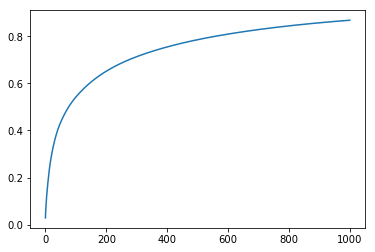

In [31]:
tsvd = TruncatedSVD(n_components=1000)
tsvd.fit(X)
plt.plot(range(1000), tsvd.explained_variance_ratio_.cumsum())

In [32]:
tsvd = TruncatedSVD(n_components=50)
tsvd.fit(X)
X_tsvd = tsvd.transform(X)

In [34]:
# Training data model
rfc = RandomForestClassifier()
rfc.fit(X_tsvd, y_train)
rfc_score = rfc.score(X_tsvd, y_train)
conf_mat = confusion_matrix(y_train, rfc.predict(X_tsvd))
class_rep = classification_report(y_train, rfc.predict(X_tsvd))
print('Accuracy: ', rfc_score, '\n')
print('Confusion Matrix:', '\n', conf_mat, '\n')
print('Classification Report:', '\n', class_rep)

Accuracy:  0.980526101142 

Confusion Matrix: 
 [[6160    3    2]
 [  85 1998   14]
 [  63   24 1459]] 

Classification Report: 
              precision    recall  f1-score   support

   negative       0.98      1.00      0.99      6165
    neutral       0.99      0.95      0.97      2097
   positive       0.99      0.94      0.97      1546

avg / total       0.98      0.98      0.98      9808



In [36]:
# Test data model
X_test_cv = cv.transform(X_test)
X_test_svd = tsvd.transform(X_test_cv)

rfc_score_test = rfc.score(X_test_svd, y_test)
conf_mat_test = confusion_matrix(y_test, rfc.predict(X_test_svd))
class_rep_test = classification_report(y_test, rfc.predict(X_test_svd))
print('Accuracy: ', rfc_score_test, '\n')
print('Confusion Matrix:', '\n', conf_mat_test, '\n')
print('Classification Report:', '\n', class_rep_test)

# 69% overall accuracy
# recall on negative tweets is good (0.92), not as good on neutral (0.32) and positive (0.28) tweets

Accuracy:  0.690397350993 

Confusion Matrix: 
 [[2787  161   65]
 [ 615  320   67]
 [ 467  121  229]] 

Classification Report: 
              precision    recall  f1-score   support

   negative       0.72      0.92      0.81      3013
    neutral       0.53      0.32      0.40      1002
   positive       0.63      0.28      0.39       817

avg / total       0.67      0.69      0.65      4832

